In [32]:
# This code has been migrated to diffusers but can be run locally with
# pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-256", custom_pipeline="audio-diffusion/audiodiffusion/pipeline_audio_diffusion.py")

# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import warnings
from typing import Callable, Union

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.schedulers.scheduling_utils import SchedulerMixin
from torchaudio import transforms as AT
from torchvision import transforms as IT
import torch
import random
from diffusers import DiffusionPipeline
from IPython.display import Audio
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import os

warnings.filterwarnings("ignore")

import numpy as np  # noqa: E402

try:
    import librosa  # noqa: E402

    _librosa_can_be_imported = True
    _import_error = ""
except Exception as e:
    _librosa_can_be_imported = False
    _import_error = (
        f"Cannot import librosa because {e}. Make sure to correctly install librosa to be able to install it."
    )


from PIL import Image  # noqa: E402


class Mel(ConfigMixin, SchedulerMixin):
    """
    Parameters:
        x_res (`int`): x resolution of spectrogram (time)
        y_res (`int`): y resolution of spectrogram (frequency bins)
        sample_rate (`int`): sample rate of audio
        n_fft (`int`): number of Fast Fourier Transforms
        hop_length (`int`): hop length (a higher number is recommended for lower than 256 y_res)
        top_db (`int`): loudest in decibels
        n_iter (`int`): number of iterations for Griffin Linn mel inversion
    """

    config_name = "mel_config.json"

    @register_to_config
    def __init__(
        self,
        x_res: int = 256,
        y_res: int = 256,
        sample_rate: int = 22050,
        n_fft: int = 2048,
        hop_length: int = 512,
        top_db: int = 80,
        n_iter: int = 32,
    ):
        self.hop_length = hop_length
        self.sr = sample_rate
        self.n_fft = n_fft
        self.top_db = top_db
        self.n_iter = n_iter
        self.set_resolution(x_res, y_res)
        self.audio = None

        if not _librosa_can_be_imported:
            raise ValueError(_import_error)

    def set_resolution(self, x_res: int, y_res: int):
        """Set resolution.

        Args:
            x_res (`int`): x resolution of spectrogram (time)
            y_res (`int`): y resolution of spectrogram (frequency bins)
        """
        self.x_res = x_res
        self.y_res = y_res
        self.n_mels = self.y_res
        self.slice_size = self.x_res * self.hop_length - 1

    def load_audio(self, audio_file: str = None, raw_audio: np.ndarray = None):
        """Load audio.

        Args:
            audio_file (`str`): must be a file on disk due to Librosa limitation or
            raw_audio (`np.ndarray`): audio as numpy array
        """
        if audio_file is not None:
            self.audio, _ = librosa.load(audio_file, mono=True, sr=self.sr)
        else:
            self.audio = raw_audio

        # Pad with silence if necessary.
        if len(self.audio) < self.x_res * self.hop_length:
            self.audio = np.concatenate([self.audio, np.zeros((self.x_res * self.hop_length - len(self.audio),))])

    def get_number_of_slices(self) -> int:
        """Get number of slices in audio.

        Returns:
            `int`: number of spectograms audio can be sliced into
        """
        return len(self.audio) // self.slice_size

    def get_audio_slice(self, slice: int = 0) -> np.ndarray:
        """Get slice of audio.

        Args:
            slice (`int`): slice number of audio (out of get_number_of_slices())

        Returns:
            `np.ndarray`: audio as numpy array
        """
        return self.audio[self.slice_size * slice : self.slice_size * (slice + 1)]

    def get_sample_rate(self) -> int:
        """Get sample rate:

        Returns:
            `int`: sample rate of audio
        """
        return self.sr

    def audio_slice_to_image(self, slice: int, ref: Union[float, Callable] = np.max, func=None) -> Image.Image:
        """Convert slice of audio to spectrogram.

        Args:
            slice (`int`): slice number of audio to convert (out of get_number_of_slices())
            ref (`Union[float, Callable]`): reference value for spectrogram

        Returns:
            `PIL Image`: grayscale image of x_res x y_res
        """
        S = librosa.feature.melspectrogram(
            y=self.get_audio_slice(slice), sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
        )

        if func!= None: S = func(S)

        log_S = librosa.power_to_db(S, ref=ref, top_db=self.top_db)
        bytedata = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
        image = Image.fromarray(bytedata)
        return image

    def image_to_audio(self, image: Image.Image) -> np.ndarray:
        """Converts spectrogram to audio.

        Args:
            image (`PIL Image`): x_res x y_res grayscale image

        Returns:
            audio (`np.ndarray`): raw audio
        """
        bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
        log_S = bytedata.astype("float") * self.top_db / 255 - self.top_db
        S = librosa.db_to_power(log_S)
        audio = librosa.feature.inverse.mel_to_audio(
            S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
        )
        return audio

In [128]:
def time_shift(spec, max_shift=256):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(spec, shift, axis=1)

def frequency_mask(spec, freq_mask_param=10):
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, spec.shape[0] - f)
    spec[f0:f0 + f, :] = 0
    return spec

def add_noise(spec, noise_level=0.01):
    noise = np.random.normal(0, noise_level, spec.shape)
    return spec + noise

def adjust_contrast(spec, factor_range=(0.8, 1.2)):
    factor = np.random.uniform(*factor_range)
    return spec * factor

def time_mask(spec, time_mask_param=10):
    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, spec.shape[1] - t)
    spec[:, t0:t0 + t] = 0
    return spec

In [129]:
mel = Mel()

In [140]:
resampler = AT.Resample(22100, 22100, dtype=torch.float32)
to_t = IT.ToTensor()
def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32)
  audio_tensor = resampler(audio_tensor)
  mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = mel.get_number_of_slices()
  print(num_slices)
  slice_idx = random.randint(0, num_slices-1) # Pic a random slice each time (excluding the last short slice)
  im = mel.audio_slice_to_image(slice_idx, func=time_shift)
  return im

In [141]:
 # Load an example audio file
audio_file = "maestro\samples\MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1_001.wav"  
y, sr = librosa.load(audio_file, sr=26200) # 26200:512, 13100:256


In [142]:
img = to_image(y)

1


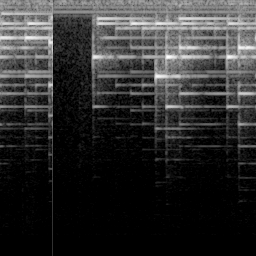

In [143]:
img

In [133]:
type(img)

PIL.Image.Image

In [134]:
a = mel.image_to_audio(img)

In [76]:
from IPython.display import Audio
display(Audio(a, rate=22100))

In [77]:
resampler = AT.Resample(48000, 22050, dtype=torch.float32)
to_t = IT.ToTensor()
folder_path='maestro/tracks'
output_dir = "clean_dataset\images"
sum = 0
counter = 0
for filename in os.listdir(folder_path):
    # Check if the file is a .txt file
    if filename.endswith('.wav'):
        # Construct full file path
        audio_file = os.path.join(folder_path, filename)
        y, sr = librosa.load(audio_file, sr=48000)
        audio_tensor = torch.tensor(y).to(torch.float32)
        audio_tensor = resampler(audio_tensor)
        mel.load_audio(raw_audio=np.array(audio_tensor))
        num_slices = mel.get_number_of_slices()
        sum += num_slices
        print(num_slices)
        for i in range(num_slices):
            im = mel.audio_slice_to_image(i)
            output_file = os.path.join(output_dir, f"{counter}.png")
            #im.save(output_file)
        counter+=1

98
118


KeyboardInterrupt: 